In [23]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import sqlite3
import taxis
from utils import *
from visualize import *
from sklearn.linear_model import *
from sklearn.kernel_ridge import *
from sklearn.pipeline import *
from sklearn.preprocessing import *
from datetime import datetime
from sklearn.cluster import *
from sklearn.svm import *
from sklearn.ensemble import *
from sklearn.neighbors import *
from matplotlib import cm

DBNAME="../taxis.db"
LAT=1.380766
LON=103.891675
LAT1=1.303693
LON1=103.844952

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
holidays=['20170626']
def peak(h,m,w):
    return 1 if ((w==1 and (h>=6 and (h <=9 and m<30)) or (h >= 18))) else 0

def weekday(d):
    dt=datetime.strptime(d,"%Y%m%d")
    return 1 if datetime.isoweekday(dt)<6 else 0

df=taxis.get_df_all_taxi_data(DBNAME,LAT1,LON1)
df['Hour']=df.apply(lambda r:int(r['Time'][:2]),axis=1)
df['Minute']=df.apply(lambda r:int(r['Time'][2:]),axis=1)
df['Weekday']=df.apply(lambda r: weekday(r['Date']),axis=1)
df['Holiday']=df.apply(lambda r: 1 if r['Date'] in holidays else 0,axis=1)
df['PeakHour']=df.apply(lambda r: peak(r['Hour'],r['Minute'],r['Weekday']),axis=1)


In [3]:
df.tail()

,Point,Date,Time,X,Y,TaxiCount,Hour,Minute,Weekday,Holiday,PeakHour
4119,4119,20170708,2330,20,5,20,23,30,0,0,1
4120,4120,20170708,2335,20,5,18,23,35,0,0,1
4121,4121,20170708,2340,20,5,25,23,40,0,0,1
4122,4122,20170708,2345,20,5,28,23,45,0,0,1
4123,4123,20170708,2350,20,5,23,23,50,0,0,1


In [4]:
h=df.quantile(q=0.8)['TaxiCount']
l=df.quantile(q=0.2)['TaxiCount']

In [19]:
df_sub=df.query('(TaxiCount>=@l and TaxiCount<=@h) and (Hour>=6 and Hour<=12) and Weekday==1')[['Point','Hour','Minute','PeakHour','Weekday','Holiday','TaxiCount']]
df_sub.head()

,Point,Hour,Minute,PeakHour,Weekday,Holiday,TaxiCount
546,546,7,20,1,1,1,34
547,547,7,25,1,1,1,27
549,549,7,35,0,1,1,27
550,550,7,40,0,1,1,28
553,553,7,55,0,1,1,35


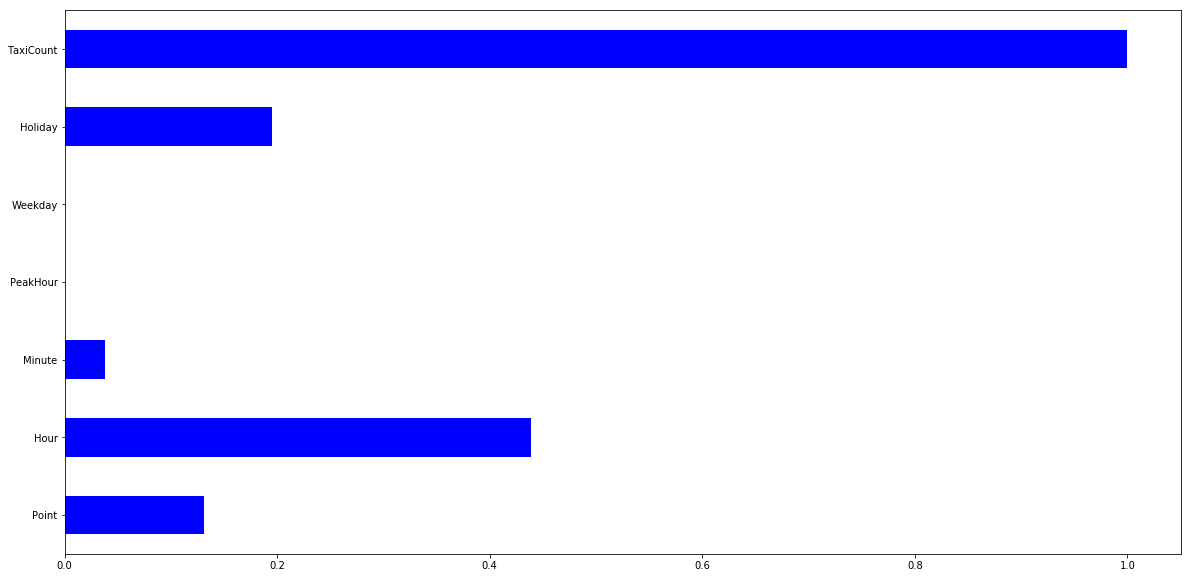

In [6]:
corr=df_sub.corr()['TaxiCount'].plot(kind='barh',color='b')
plt.show()

In [20]:
f=df_sub['Point'].count()
c=int(f*0.8)
d=f-c
print c
print d
training=df_sub.head(c)
testing=df_sub.tail(d)

340
86


In [21]:
X=training.drop(['Point','TaxiCount'],axis=1).as_matrix()
y=np.array(training['TaxiCount'].tolist()).reshape(-1,1)

rf=RandomForestRegressor(n_estimators=100,criterion='mse',oob_score=True,n_jobs=5).fit(X,y)
print rf

print rf.score(X,y)
print rf.feature_importances_
print rf.n_outputs_

#plt.plot(y,color='g')
#plt.plot(rf.predict(X),color='r')
plt.show()


/Users/hari/python/py2/taxidata/lib/python2.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=5, oob_score=True, random_state=None,
           verbose=0, warm_start=False)
0.791027410576
[ 0.80650298  0.13893144  0.01384273  0.          0.04072285]
1


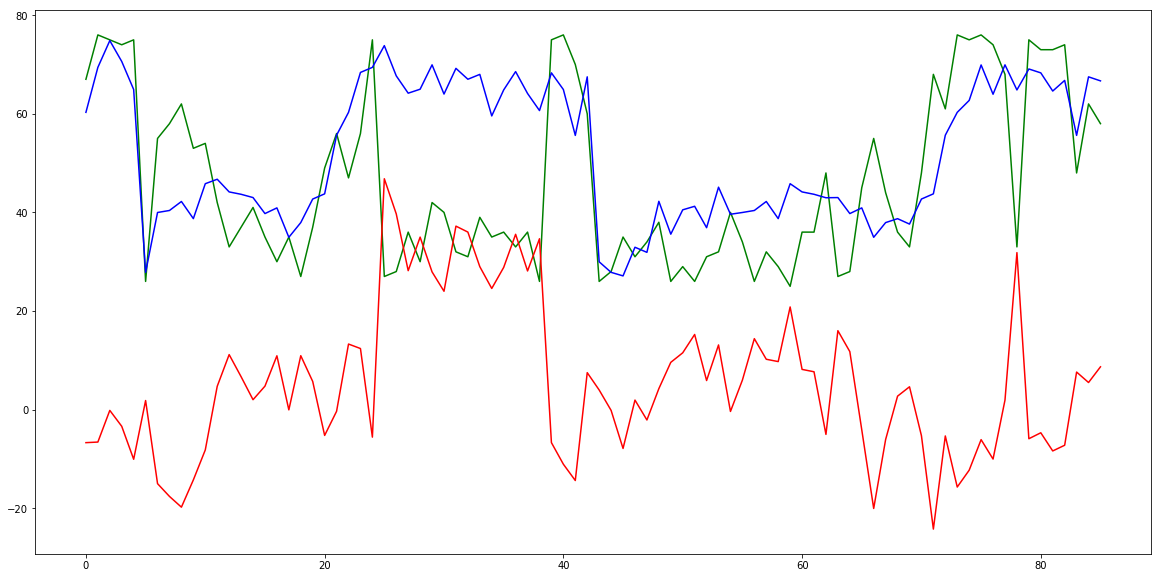

In [22]:
Xt=testing.drop(['Point','TaxiCount'],axis=1).as_matrix()
yt=np.array(testing['TaxiCount'].tolist()).reshape(-1,1)
P=rf.predict(Xt)
e=[x-y for x,y in zip(P,yt)]

plt.plot(yt,color='g')
plt.plot(P,color='b')
plt.plot(e,color='r')
plt.show()

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='distance')
0.794420187465


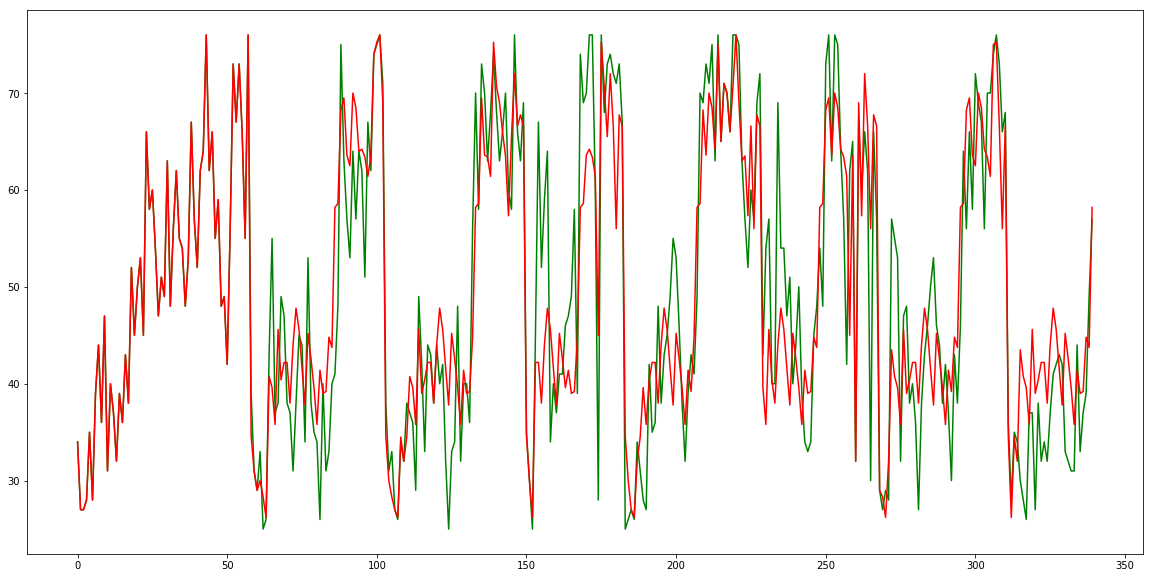

In [28]:
X=training.drop(['Point','TaxiCount'],axis=1).as_matrix()
y=np.array(training['TaxiCount'].tolist()).reshape(-1,1)

kn=KNeighborsRegressor(weights='distance').fit(X,y)

print kn

print kn.score(X,y)

plt.plot(y,color='g')
plt.plot(kn.predict(X),color='r')
plt.show()

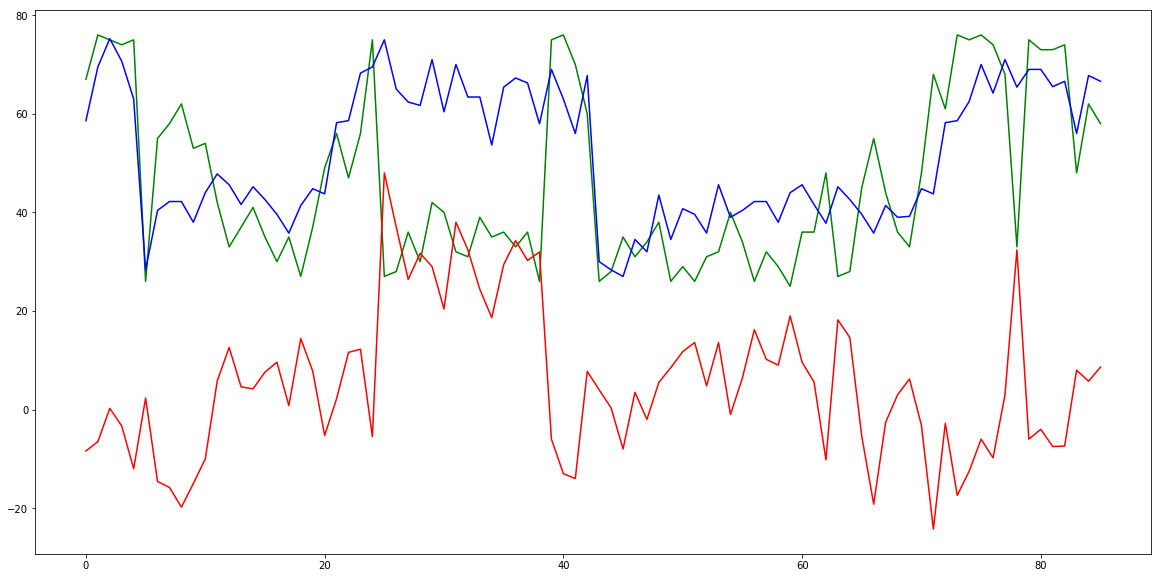

In [30]:
Xt=testing.drop(['Point','TaxiCount'],axis=1).as_matrix()
yt=np.array(testing['TaxiCount'].tolist()).reshape(-1,1)
P=kn.predict(Xt)
e=[x-y for x,y in zip(P,yt)]

plt.plot(yt,color='g')
plt.plot(P,color='b')
plt.plot(e,color='r')
plt.show()